In [67]:
import transformers
import torch
import tensor_parallel as tp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
#from fuzzywuzzy import fuzz

In [68]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto")

input_text = "translate English to German: How old are you?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))



NameError: name 'init_empty_weights' is not defined

In [85]:
#from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

#model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-xl")
#tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl")

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")


In [74]:
model = tp.tensor_parallel(model)

In [75]:
#reading dataset
temp_dataset = pd.read_csv('Dataset 696 - Sheet1.csv', header = None)
temp_dataset.head()

,0,1,2,3
0,Instructions,Labels,Links,Notes
1,1. Go to Transactions > Bank > Make Deposits >...,"click[Transactions], click[Bank], click[Make D...",https://docs.oracle.com/en/cloud/saas/netsuite...,NaN
2,1. Go to Transactions > Bank > Make Deposits >...,"click[Transactions], click[Bank], click[Make D...",https://docs.oracle.com/en/cloud/saas/netsuite...,NaN
3,1. Go to Setup > Users/Roles > Manage Roles. 2...,"click[Setup], click[Users/Roles], click[Manage...",https://docs.oracle.com/en/cloud/saas/netsuite...,NaN
4,"1. From the Deposits list, click Customize Vie...","click[Customize View], click[Available Filters...",NaN,NaN


In [76]:
from sentence_transformers import SentenceTransformer, util
em_model = SentenceTransformer('all-MiniLM-L6-v2')

In [83]:
def Predict(input, data, dataset):
    prompt_str = "Please answer to the following question: "
    
    for index, row in data.iterrows():
        new_row = dataset.loc[dataset[0] == row[0]]
        prompt_str = prompt_str + new_row[0] + " => " + new_row[1] + ". "
        
    input_str = prompt_str + " "+ str(input)+ " =>"
    print("input string", input_str)
    inputs = tokenizer(str(input_str), return_tensors="pt", padding = True)
    outputs = model.generate(**inputs, max_new_tokens=500)
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [78]:
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


In [79]:
def In_Context_Example(test_sentence, data):

    in_context_examples = {}
    sentences = []

    for index, row in data.iterrows():
        sentences.append(str(row[0]))

    test_embedding = em_model.encode(test_sentence)
    embeddings = em_model.encode(sentences)
      
    #Compute cosine similarity between my sentence, and each one in the corpus
    cos_sim = util.cos_sim(test_embedding, embeddings)

    # lets go through our array and find our best one!
    # remember, we want the highest value here (highest cosine similiarity)
    top_k = []
    for arr in cos_sim:
        for i, each_val in enumerate(arr):
            top_k.append([sentences[i],each_val])

    # lets get the top 2 sentences
    
    final_top_k = sorted(top_k, key=lambda x: x[1], reverse=True)
    
    return final_top_k

In [80]:
def Generate_In_Context_Examples(dataset):

    in_context_examples_dict = {}
    for index, row in dataset.iterrows():
        sliced_df = pd.concat([dataset[:index-1], dataset[index+1:]]) 
        final_top_k = In_Context_Example(row[0], sliced_df)
        in_context_examples_dict[str(row[0])] = final_top_k
    print("len", len(in_context_examples_dict))
    return in_context_examples_dict

In [81]:
from torchmetrics.text.bert import BERTScore
bertscore = BERTScore()

In [82]:
def N_shots(dataset, shots):

    in_context_examples_dict = Generate_In_Context_Examples(dataset)
    metric = {}
    for i in range(shots):
        N_shot_results = []
        count = 0
        Bertscore_metric = 0
        for j, key in enumerate(in_context_examples_dict.keys()):

            new_row = dataset.loc[dataset[0] == key]
            if count == 0:
                new_df = pd.DataFrame(in_context_examples_dict[key][:i])
                count +=1
            
            #predicted  
            predicted = str(Predict(key, new_df, dataset)).lower()
            print("Predicted", predicted)
            truth = str("['"+new_row[1]+"']").lower()
            print("truth", truth)
            
            results = bertscore( predicted, truth)
            Bertscore_metric = Bertscore_metric + results['f1']
            
        
        t = Bertscore_metric/len(dataset)
        N_shot_results.append(t)
        print(N_shot_results)
        
    return N_shot_results
            
            

In [ ]:
N_shot_results = N_shots(temp_dataset[1:10], 2)

len 9
input string Please answer to the following question:  1. Go to Transactions > Bank > Make Deposits > List. 2. From the Deposits list, click Edit next to the deposit you want to delete. 3. On the Deposit page, under Actions, click Delete. 4. At the prompt to confirm the action, click OK =>
Predicted ['1. go to transactions > bank > make deposits > list. 2. click edit next to the deposit you want to delete. 3. on the deposit page, under actions, click delete. 4.']
truth 1    ['click[transactions], click[bank], click[make...
name: 1, dtype: object


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Traceback (most recent call last):
  File "/home/yannam_umass_edu/.conda/envs/my_env_oracle/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/yannam_umass_edu/.conda/envs/my_env_oracle/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/yannam_umass_edu/.conda/envs/my_env_oracle/lib/python3.9/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/yannam_umass_edu/.conda/envs/my_env_oracle/lib/python3.9/shutil.py", line 734, in rmtree
    _rmtree_safe_fd(fd, path, onerror)
  File "/home/yannam_umass_edu/.conda/envs/my_env_oracle/lib/python3.9/shutil.py", line 690, in _rmtree_safe_fd
    onerror(os.unlink, fullname, sys.exc_info())
  File "/home/yannam_umass_edu/.conda/envs/my_env_oracle/lib/python3.9/shutil.py", line 688, in _rmtree_safe_fd
    os.unlink(entry.name, dir_fd=topfd)
OSError: [Errno 16] Device or resource busy: '.n

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
N_shot_results

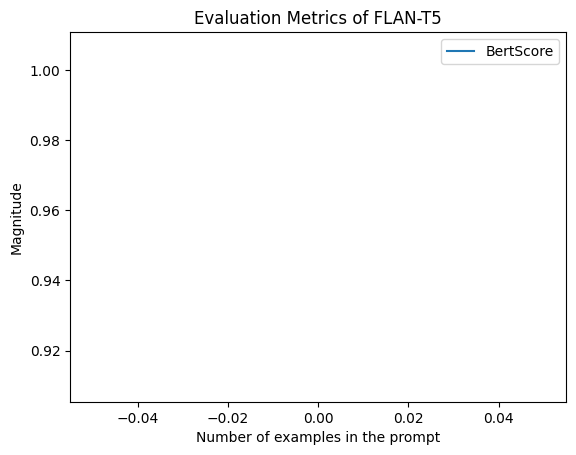

In [43]:
plt.plot(0, N_shot_results, label= 'BertScore')
plt.xlabel("Number of examples in the prompt")
plt.ylabel("Magnitude")
plt.title("Evaluation Metrics of FLAN-T5")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
plt.show()

In [52]:
!srun --account=yannam_umass_edu --partition=gypsum-titanx --mem=50G --time=4:00:00 --gres=gpu:1 --pty /bin/bash

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
srun: error: Unable to create step for job 6365292: Memory required by task is not available


In [46]:
!pip install nvidia

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement nvidia (from versions: none)
ERROR: No matching distribution found for nvidia


In [49]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fri Mar 31 13:12:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 22

In [51]:
!srun --partition=gypsum-titanx --mem=50G --time=4:00:00 --gres=gpu:1 --pty /bin/bash

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
srun: error: Unable to create step for job 6365292: Memory required by task is not available


In [18]:
TOKENIZERS_PARALLELISM=(True)